# [Exploration] 😀인공지능으로 세상에 없던 새로운 패션 만들기

<br>  
<br>  
<br>  

---

---

## STEP 1. 작업환경 구성하기

In [200]:
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

---

<br>  

## STEP 2. 데이터셋 구성하기

In [120]:
# 라이브러리 확인
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from keras.layers.convolutional import UpSampling2D, Conv2D
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [121]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [122]:
# 각 픽셀은 0~255 사이의 정숫값을 가진다.
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [123]:
# 각 픽셀을 -1에서 1로 정규화
train_x = (train_x - train_x.min()) / (train_x.max() - train_x.min())

In [124]:
train_x.shape

(50000, 32, 32, 3)

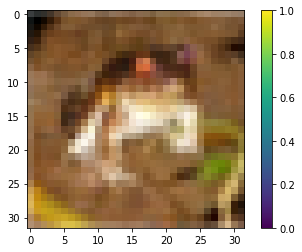

In [125]:
plt.imshow((train_x[0]))
plt.colorbar()
plt.show()

In [126]:
# plt.figure(figsize=(10, 5))

# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(train_x[i])
#     plt.title(f'index: {i}')
#     plt.axis('off')
# plt.show()

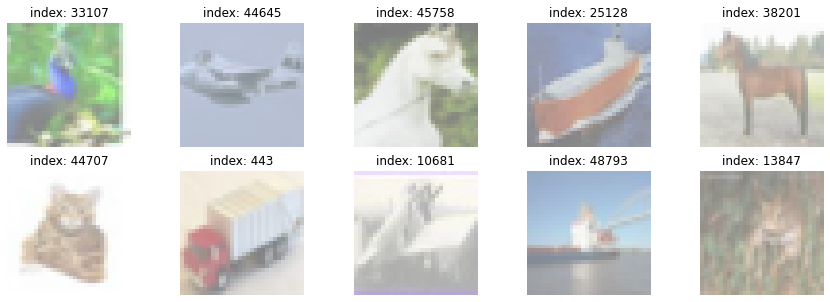

In [127]:
plt.figure(figsize=(15, 5))

for i in range(10):
    # 서브 플롯에 이미지 추가
    plt.subplot(2, 5, i+1)
    # 랜덤한 인덱스 추출
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

---

<br>  

## STEP 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 보다.  
- `noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 보자.  
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 보자.  

<br>  

In [128]:
# BUFFER_SIZE = 50000
# BATCH_SIZE = 256

In [129]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [130]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 7x7x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model


In [131]:
generator = make_generator_model()

generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_15 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 128)        

In [132]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

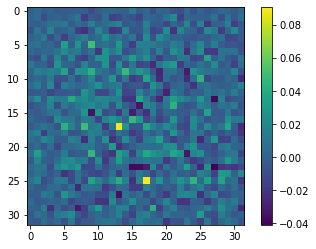

In [133]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

---

<br>  

## STEP 4. 판별자 모델 구현하기  
  
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 보자.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 보자.

In [134]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [135]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

In [136]:
# 가짜 이미지를 판별자에 입력해보자
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00350055]], dtype=float32)>

---

<br>  

## STEP 5. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 보자.  
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 보자.  
- 생성자와 판별자를 최적화하는 optimizer를 정의한다.  

In [137]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

`cross_entropy`를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.

<br>  

-  **`fake_output`**  : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 **`D(fake_image)`**  

- **`real_output`** : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 **`D(real_image)`**  

In [138]:
# 판별자의 손실함수 구현
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

판별자가 `real output`, `fake output`을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.


만약 판별자가 real output과 fake output을 `accuracy`가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋지 않다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 그래서, `real accuracy`와 `fake accuracy`는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

In [139]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [140]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [141]:
# 00차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [142]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [143]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

---

<br>  

## STEP 6. 훈련과정 상세 기능 구현하기
  
- 1개 미니배치의 훈련 과정을 처리하는 `train_step()` 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 `draw_train_history()` 함수를 구현해 봅시다.
- `training_checkpoints` 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [144]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [145]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [146]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, :])
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [147]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [148]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [149]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

---

<br>  

## STEP 7. 학습 과정 진행하기

<br>  

In [150]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

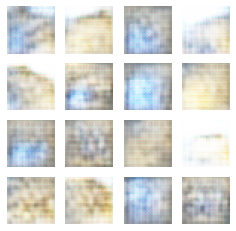

Time for training : 781 sec


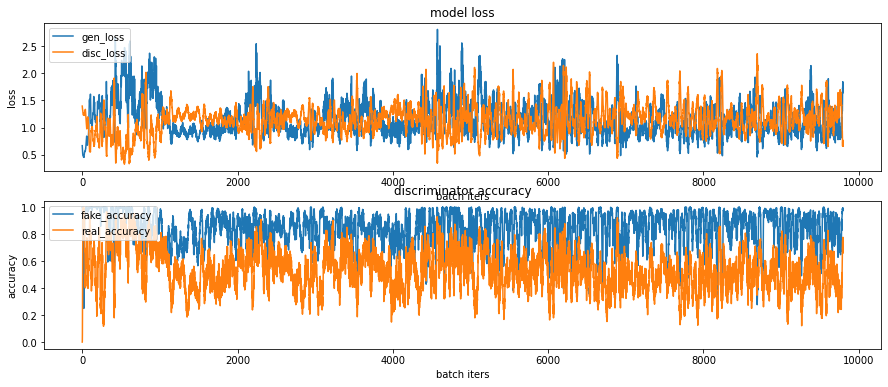

CPU times: user 13min 14s, sys: 1min 20s, total: 14min 35s
Wall time: 13min 2s


In [151]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [153]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan7.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1584060 Jan 22 08:24 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


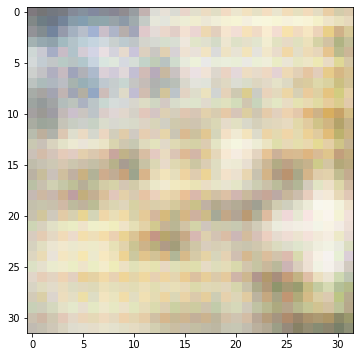

In [154]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [155]:
def make_generator_model2():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*128, activation='relu', input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization(momentum = 0.9))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2D(128, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Seventh: Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same', \
                                     activation='tanh'))
    # model.add(layers.Reshape((32, 32, 3)))
    # assert model.output_shape == (None, 32, 32, 3)

    return model

In [156]:
generator2 = make_generator_model2()

generator2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_18 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 8, 8, 128)        

In [157]:
noise = tf.random.normal([1,100])
generated_image = generator2(noise,training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [158]:
def make_discriminator_model2():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    

    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    # Sixth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))


    return model

In [159]:
discriminator2 = make_discriminator_model2()

discriminator2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 16, 16, 128)      

In [160]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)

In [161]:
BUFFER_SIZE = 50000
BATCH_SIZE = 16

In [162]:
save_every = 5
EPOCHS = 70

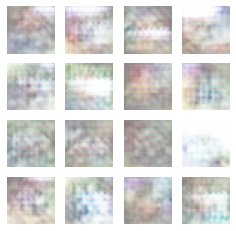

Time for training : 1099 sec


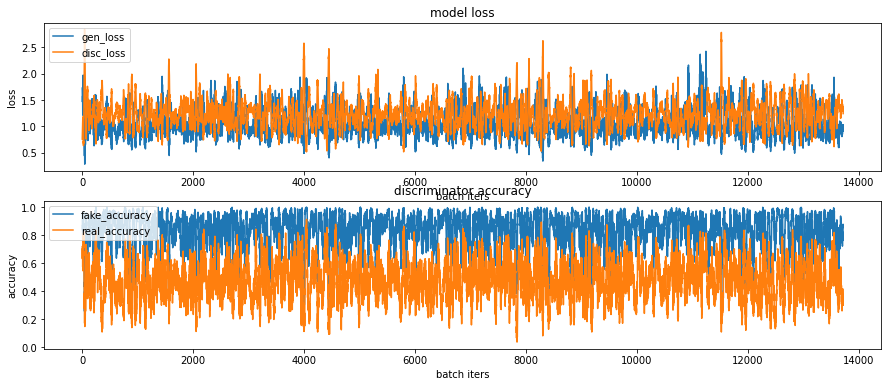

CPU times: user 18min 38s, sys: 1min 51s, total: 20min 30s
Wall time: 18min 20s


In [163]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [164]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan8.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1584060 Jan 22 08:24 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


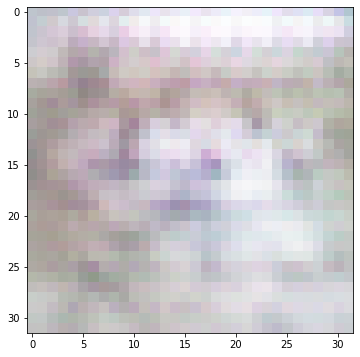

In [167]:
generated_image2 = checkpoint.generator(noise, training=False)
np_generated2 = generated_image2.numpy()
np_generated2 = (np_generated2 * 127.5) + 127.5   # reverse of normalization
np_generated2 = np_generated2.astype(int)
plt.imshow(np_generated2[0])
plt.show()

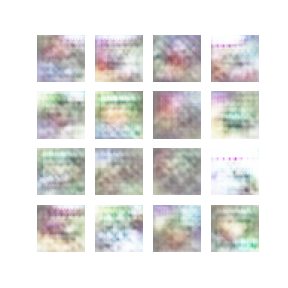

In [170]:
from IPython.display import Image
Image('/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0070_iter_051.png')

In [175]:
def make_generator_model3():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, activation='relu', input_shape=(100,), use_bias=False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization(momentum = 0.9))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', \
                                     activation='tanh', use_bias=False))
    # model.add(layers.Reshape((32, 32, 3)))
    # assert model.output_shape == (None, 32, 32, 3)

    return model

In [176]:
generator3 = make_generator_model3()

generator3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_30 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 8, 128)       

In [19]:
noise = tf.random.normal([1, 100])

In [177]:
generated_image3 = generator3(noise, training=False)
generated_image3.shape

TensorShape([1, 32, 32, 3])

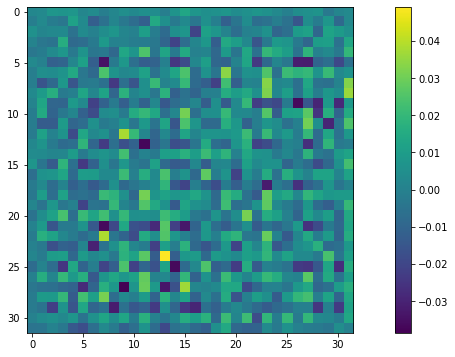

In [178]:
plt.imshow(generated_image3[0, :, :, 0])
plt.colorbar()
plt.show()

In [179]:
def make_discriminator_model3():

    # Start
    model = tf.keras.Sequential()


    model.add(layers.Conv2D(64, (3, 3), activation ='relu', padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.Conv2D(64, (3, 3), activation ='relu', padding='same'))
    model.add(layers.LeakyReLU(alpha = 0.1))
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(128, (3, 3), activation ='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation ='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))
    model.add(layers.Dropout(0.3))
    

    model.add(layers.Conv2D(128, (3, 3), activation ='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation ='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))
    model.add(layers.Dropout(0.3))
    

    model.add(layers.Conv2D(128, (3, 3), activation ='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation ='relu', padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    

    model.add(layers.Dense(512,activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))


    return model

In [180]:
discriminator3 = make_discriminator_model3()

discriminator3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 128)     

In [185]:
save_every = 5
EPOCHS = 50

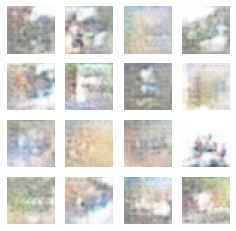

Time for training : 781 sec


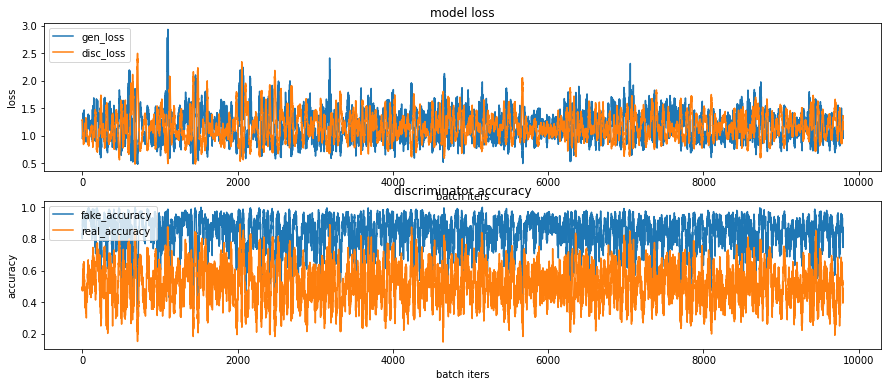

CPU times: user 13min 16s, sys: 1min 20s, total: 14min 37s
Wall time: 13min 2s


In [186]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

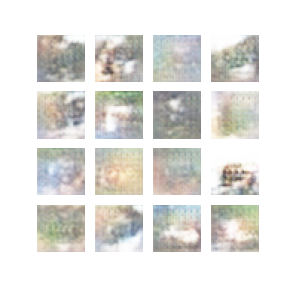

In [191]:
from IPython.display import Image
Image('/aiffel/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0050_iter_101.png')

In [192]:
def make_generator_model2():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*128, activation='relu', input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization(momentum = 0.9))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2D(128, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Seventh: Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same', \
                                     activation='tanh'))
    # model.add(layers.Reshape((32, 32, 3)))
    # assert model.output_shape == (None, 32, 32, 3)

    return model

In [193]:
generator2 = make_generator_model2()

generator2.summary()

noise = tf.random.normal([1,100])
generated_image = generator2(noise,training=False)
generated_image.shape

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 8192)              827392    
_________________________________________________________________
batch_normalization_46 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_47 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 8, 8, 128)       

TensorShape([1, 32, 32, 3])

In [194]:
def make_discriminator_model2():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    

    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    # Sixth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))


    return model


In [195]:
discriminator2 = make_discriminator_model2()

discriminator2.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_52 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_53 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 16, 16, 128)     

In [196]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5)

BUFFER_SIZE = 50000
BATCH_SIZE = 16

In [197]:
save_every = 5
EPOCHS = 100

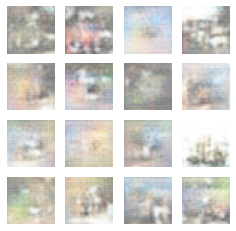

Time for training : 1585 sec


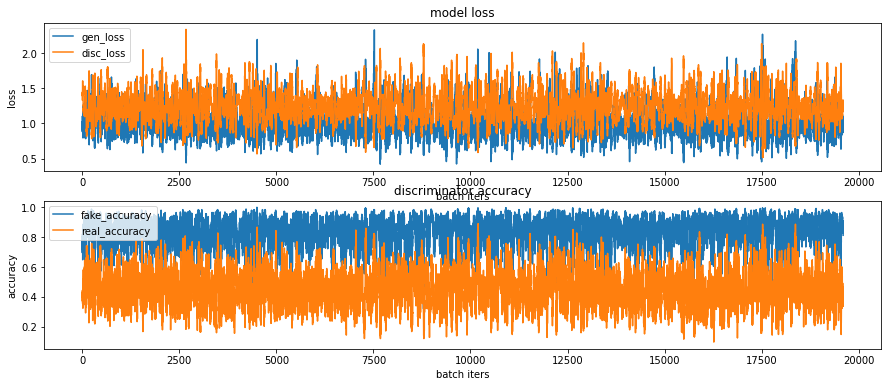

CPU times: user 26min 57s, sys: 2min 39s, total: 29min 37s
Wall time: 26min 27s


In [198]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [199]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan9.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1584060 Jan 22 08:24 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


---

<br>  
<br>  
<br>  

## ⛓️회고

### - Keep
tutorial 노드를 적극 활용하였다.. 만져봤다는 것에 의미를 두자라고 생각했다.


### - Problem
GAN모델이 예민하다고 듣기는 했지만 생각보다 더 손대기 어려웠다. dimc loss를 어떻게 해야 낮출 수 있을지를 고민하는데에 시간을 많이 소비했고, 파라미터를 조금씩 바꿔가면서 학습시키자니 제한된 시간에 쫓겼다. 육안으로 모양을 알아볼 수 있는 것이 없었고, fake acuuracy도 하향하고 있지 않은 것 같다..    



### - Try
코드를 조금 더 간결하고 간단하게 짜보도록 더 깊게 생각해보자.여전히 불필요한 코드가 많은 것 같다..💧